In [288]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib import cm
from datetime import datetime
import os
import urllib.request
%matplotlib inline
sns.set(style="ticks", color_codes=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [289]:
def parse_matchup(path, left_owner, right_owner):
    tables = pd.read_html(path, header=0)
    stats_df = tables[2]
    stats_df.drop(['Stats', 'Unnamed: 5', 'Stats.1'], axis=1, inplace=True)
    stats_df['player_name_01'] = stats_df['Player'].str.extract(r'Note(.+)\s\-', expand=True)
    stats_df['player_name_02'] = stats_df['Player.1'].str.extract(r'Note(.+)\s\-', expand=True)
    stats_df['player_name_01'] = stats_df['player_name_01'].apply(lambda x : x[2:] if str(x).startswith('s ') else x)
    stats_df['player_name_02'] = stats_df['player_name_02'].apply(lambda x : x[2:] if str(x).startswith('s ') else x)
    stats_df['team_01'] = stats_df['player_name_01'].apply(lambda x : str(x).split(' ')[-1])
    stats_df['team_02'] = stats_df['player_name_02'].apply(lambda x : str(x).split(' ')[-1])
    stats_df.drop(['Player', 'Player.1'], axis=1, inplace=True)
    stats_df = stats_df[stats_df['Pos'] != 'Total']
    stats_df.columns = ['proj_01', 'act_01', 'pos_01', 'pos_02', 'act_02', 'proj_02', 'player_01', 'player_02', 'team_01', 'team_02']
    stats_df = stats_df[['player_01', 'team_01', 'pos_01', 'proj_01', 'act_01', 'player_02', 'team_02', 'pos_02', 'proj_02', 'act_02']]
    owner_1 = stats_df[stats_df.columns[:5]].copy(deep=True)
    owner_1['owner'] = left_owner
    owner_1.columns = ['player', 'team', 'pos', 'proj', 'act', 'owner']
    owner_2 = stats_df[stats_df.columns[5:]].copy(deep=True)
    owner_2['owner'] = right_owner
    owner_2.columns = ['player', 'team', 'pos', 'proj', 'act', 'owner']
    return pd.concat([owner_1, owner_2])

In [290]:
def process_matchups(week):
    dfs = list()
    matchup_dir = r'C:\Users\sdemarco\Documents\fant\matchups\{}'.format(week)
    for fn in os.listdir(matchup_dir):
        lo, ro = fn.split('-')
        ro = ro.replace('.html', '')
        dfs.append(parse_matchup(path=os.path.join(matchup_dir, fn), left_owner=lo, right_owner=ro))
        print("{} VS {} complete.".format(lo, ro))
    df = pd.concat(dfs)
    df.reset_index()
    return df

In [291]:
df = process_matchups('week_01')
df['dif'] = df.act - df.proj
df['pct_dif'] = df.dif / df.proj * 100
df.describe()

@barstoolbass VS The Old Bol & Chain complete.
Donny Moscow VS Pasta La Vista complete.
Scoopin' Dubs VS Poppa Kommy the Wise complete.
The Red Rockets VS We are the smes! complete.
Time to Refi VS Big Data Little Dick complete.


,proj,act,dif,pct_dif
count,90.000,90.000,90.000,90.000
mean,13.357,13.002,-0.355,-3.559
std,4.161,9.293,8.133,64.960
min,4.830,-4.000,-13.650,-149.444
25%,9.940,7.025,-6.568,-47.590
50%,12.480,11.100,-1.345,-11.364
75%,16.060,17.875,3.853,33.646
max,22.350,41.800,28.940,225.039


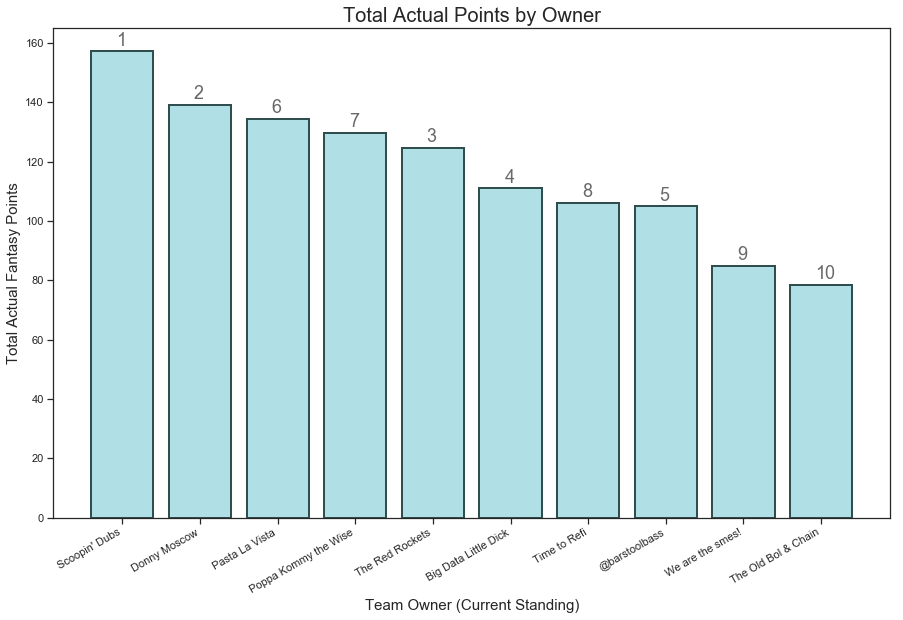

In [292]:
total_pts = df.groupby('owner')['act'].sum().reset_index().sort_values(by='act', ascending=False)
total_pts
objects = total_pts['owner'].values.tolist()
y_pos = np.arange(len(objects))
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.bar(y_pos, total_pts['act'], align='center', edgecolor='darkslategray', color='powderblue', linewidth=2)
places = [1, 2, 6, 7, 3, 4, 8, 5, 9, 10]
ax.set_alpha(0.8)
for i, x in zip(ax.patches, places):
    ax.text(i.get_x()+.32, i.get_height()+2, '{}'.format(x), fontsize=18, color='dimgrey')
plt.gcf().autofmt_xdate()
plt.xticks(y_pos, objects)
plt.title('Total Actual Points by Owner', fontsize=20)
plt.xlabel('Team Owner (Current Standing)', fontsize=15)
plt.ylabel('Total Actual Fantasy Points', fontsize=15)
plt.show()
fig.savefig('total_pts.png')

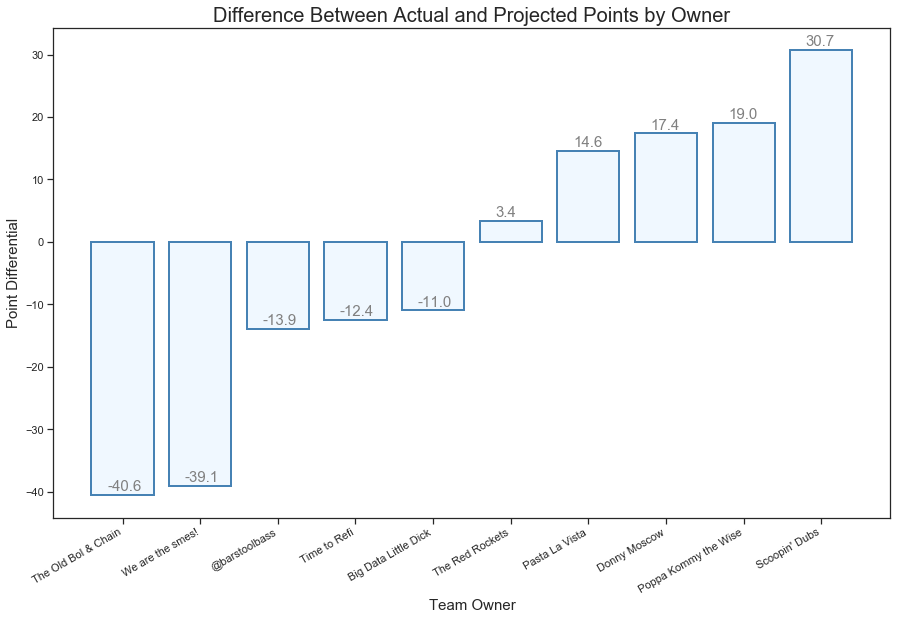

In [293]:
total_dif = df.groupby('owner')['dif'].sum().reset_index().sort_values(by='dif')
objects = total_dif['owner'].values.tolist()
y_pos = np.arange(len(objects))
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.bar(y_pos, total_dif['dif'], align='center', color='aliceblue', edgecolor='steelblue', linewidth=2)
ax.set_alpha(0.8)
plt.gcf().autofmt_xdate()
plt.xticks(y_pos, objects)
plt.title('Difference Between Actual and Projected Points by Owner', fontsize=20)
plt.xlabel('Team Owner', fontsize=15)
plt.ylabel('Point Differential', fontsize=15)
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height()+.65, '{0:.1f}'.format(i.get_height()), fontsize=15, color='gray')
plt.show()
fig.savefig('total_pt_dif.png')

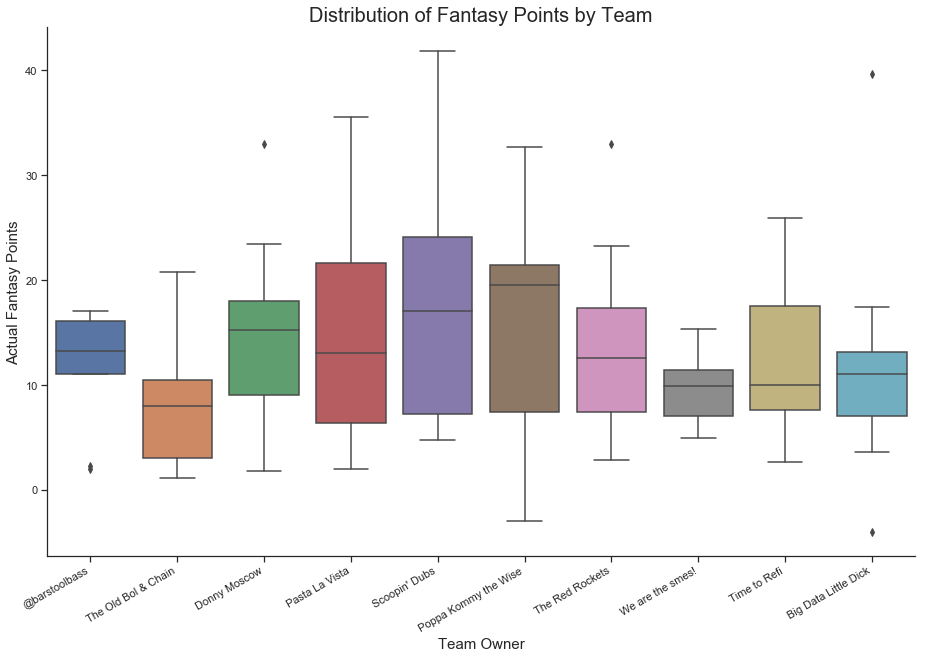

In [294]:
fig = sns.catplot(x="owner", y="act", kind="box", data=df, height=9.5, aspect=13/9.5)
plt.gcf().autofmt_xdate()
plt.xlabel('Team Owner', fontsize=15)
plt.ylabel('Actual Fantasy Points', fontsize=15)
plt.title('Distribution of Fantasy Points by Team' ,fontsize=20)
plt.show()
fig.savefig('pt_dist.png')

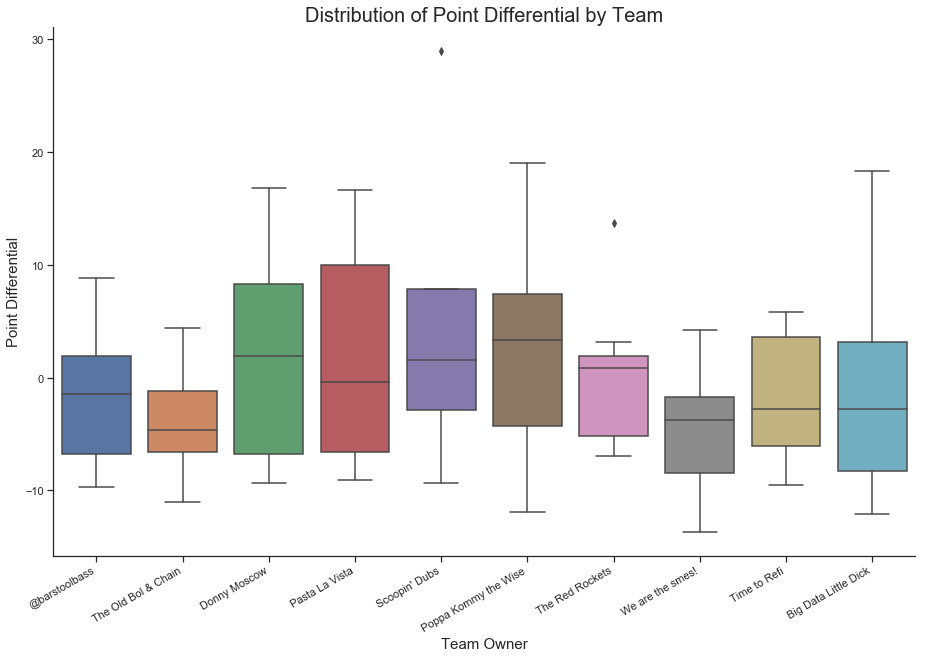

In [295]:
fig = sns.catplot(x="owner", y="dif", kind="box", data=df, height=9.5, aspect=13/9.5)
plt.gcf().autofmt_xdate()
plt.xlabel('Team Owner', fontsize=15)
plt.ylabel('Point Differential', fontsize=15)
plt.title('Distribution of Point Differential by Team' ,fontsize=20)
plt.show()
fig.savefig('pt_dif_dist.png')

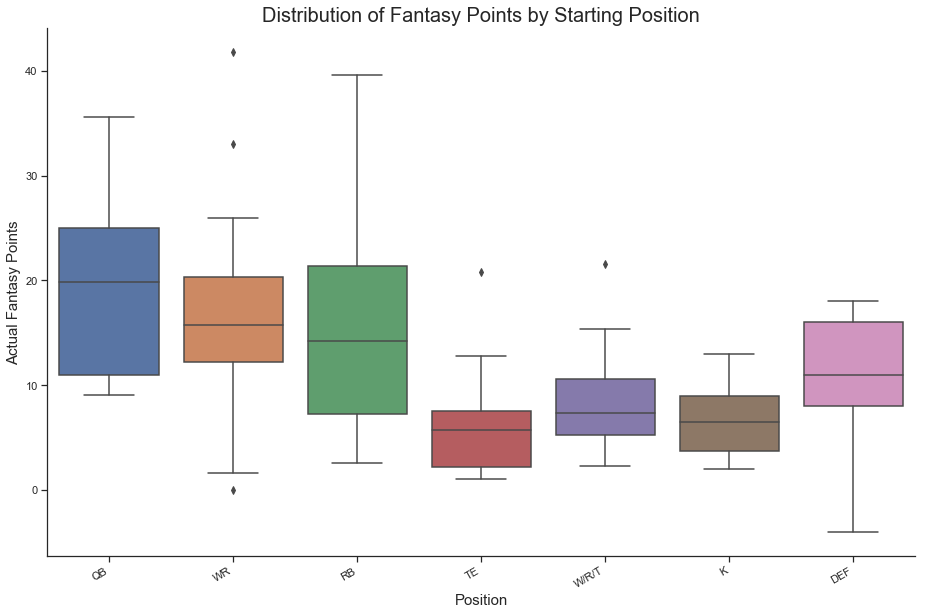

In [296]:
fig = sns.catplot(x="pos", y="act", kind="box", data=df, height=9.5, aspect=13/9.5)
plt.gcf().autofmt_xdate()
plt.xlabel('Position', fontsize=15)
plt.ylabel('Actual Fantasy Points', fontsize=15)
plt.title('Distribution of Fantasy Points by Starting Position' ,fontsize=20)
plt.show()
fig.savefig('pos_pt_dist.png')

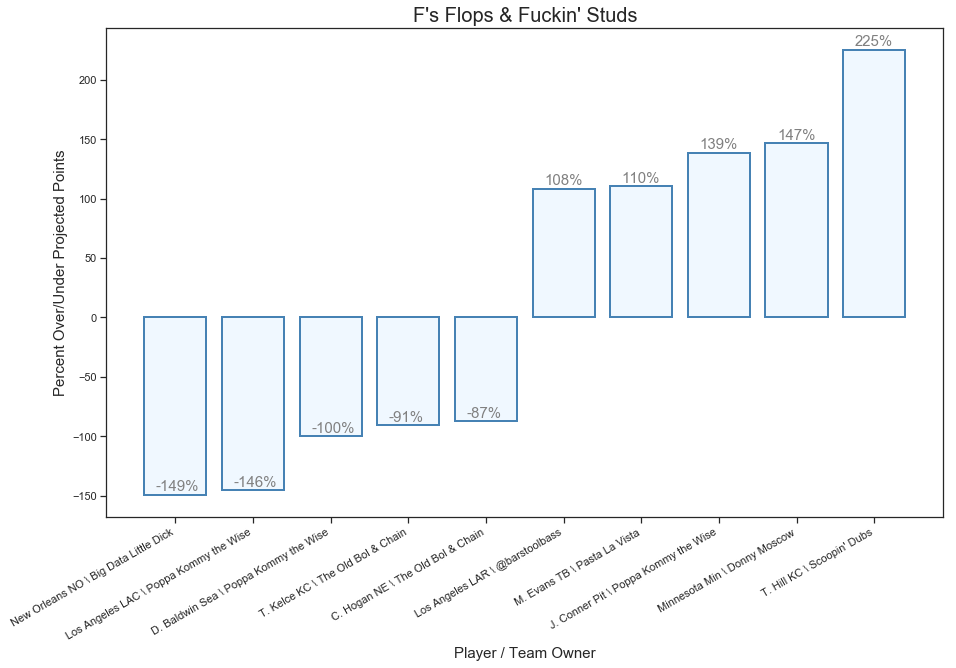

In [298]:
sorted_players = df[df['pos']!='K'].sort_values(by='pct_dif')
fs = pd.concat([awful_players.head(5), awful_players.tail(5)])
fs['player_owner'] = fs['player'] + ' \ ' + fs['owner']

objects = fs['player_owner'].values.tolist()
y_pos = np.arange(len(objects))
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.bar(y_pos, fs['pct_dif'], align='center', color='aliceblue', edgecolor='steelblue', linewidth=2)
ax.set_alpha(0.8)
plt.gcf().autofmt_xdate()
plt.xticks(y_pos, objects)
plt.title("F's Flops & Fuckin' Studs", fontsize=20)
plt.xlabel('Player / Team Owner', fontsize=15)
plt.ylabel('Percent Over/Under Projected Points', fontsize=15)
for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+3.5, '{0:.0f}%'.format(i.get_height()), fontsize=15, color='gray')
plt.show()
fig.savefig('flops_studs.png')

In [301]:
df[df['owner']=='We are the smes!'].sort_values(by='act')

,player,team,pos,proj,act,owner,dif,pct_dif
4,K. Hunt KC,KC,RB,16.780,4.900,We are the smes!,-11.880,-70.799
7,W. Lutz NO,NO,K,9.710,6.000,We are the smes!,-3.710,-38.208
3,L. Fournette Jax,Jax,RB,20.650,7.000,We are the smes!,-13.650,-66.102
5,Z. Ertz Phi,Phi,TE,11.720,7.300,We are the smes!,-4.420,-37.713
0,M. Ryan Atl,Atl,QB,18.320,9.840,We are the smes!,-8.480,-46.288
1,L. Fitzgerald Ari,Ari,WR,12.770,11.100,We are the smes!,-1.670,-13.078
6,L. Miller Hou,Hou,W/R/T,14.650,11.400,We are the smes!,-3.250,-22.184
8,Denver Den,Den,DEF,7.760,12.000,We are the smes!,4.240,54.639
2,D. Thomas Den,Den,WR,11.560,15.300,We are the smes!,3.740,32.353
